In [2]:
import corr
import utils
import matplotlib.pyplot as plt
import numpy as np

In [3]:
frames = utils.load_example_experiment()

In [4]:
frames = np.array(frames)
print(frames.shape)

(764, 258, 512)


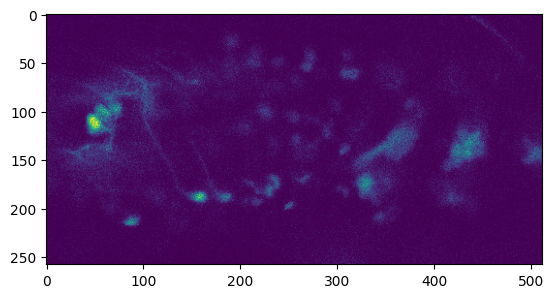

In [5]:
plt.imshow(frames[0])

In [6]:
def get_neighbor_coords(image: np.ndarray, x: int, y: int) -> list[tuple[int, int]]:
    H, W = image.shape[0], image.shape[1]
    x_neighbors = [-1, 0, 1]
    y_neighbors = [-1, 0, 1]
    neighbor_coords = []
    for dx in x_neighbors:
        for dy in y_neighbors:

            nx, ny = x + dx, y + dy
            if 0 <= nx < W and 0 <= ny < H:
                if not (dx == 0 and dy == 0):
                    neighbor_coords.append((nx, ny))
    return neighbor_coords


In [7]:
def get_corr_with_neighbors(image_stack: np.ndarray, x: int, y:int) -> float:
    """:param image_stack: (N, H, W) array of N timepoints of HxW images
    :param x: x coordinate of the pixel
    :param y: y coordinate of the pixel
    """
    neighbor_coords = get_neighbor_coords(image_stack[0], x, y)

    pixel_fl_time_series = image_stack[:, y, x]
    neighbors_fl_time_series = np.stack([image_stack[:, ny, nx] for nx, ny in
                                         neighbor_coords], axis=1)
    neighbors_mean_time_series = neighbors_fl_time_series.mean(axis=1)
    corr = np.corrcoef(pixel_fl_time_series, neighbors_mean_time_series)[0, 1]
    return corr

In [8]:
corr_test_pixel = get_corr_with_neighbors(frames, 0, 0)
print(corr_test_pixel)

0.0037697700534692065


In [9]:
def calculate_all_corrs(image_stack: np.ndarray) -> np.ndarray:
    H, W = image_stack.shape[1], image_stack.shape[2]
    corrs = np.zeros_like(image_stack[0])
    for x in range(W):
        for y in range(H):
            corr = get_corr_with_neighbors(image_stack, x, y)
            corrs[y, x] = corr
    corrs = (corrs - corrs.min()) / (corrs.max() - corrs.min())
    return corrs

In [10]:
corrs = calculate_all_corrs(frames)

In [11]:
corrs

array([[0.08381035, 0.07543316, 0.09159941, ..., 0.08847346, 0.14046459,
        0.1183391 ],
       [0.05546761, 0.09335698, 0.11779371, ..., 0.09737607, 0.11093727,
        0.12469175],
       [0.08227758, 0.13255952, 0.12896132, ..., 0.09366263, 0.07401257,
        0.07675282],
       ...,
       [0.14302915, 0.104821  , 0.22340226, ..., 0.15938886, 0.10412239,
        0.14363964],
       [0.17385964, 0.14158921, 0.18811427, ..., 0.23186265, 0.22693408,
        0.19408903],
       [0.11670562, 0.17057475, 0.15259966, ..., 0.23286508, 0.23507737,
        0.1741631 ]], dtype=float32)

In [12]:
np.argmax(corrs)

108119

In [13]:
np.max(corrs)

1.0

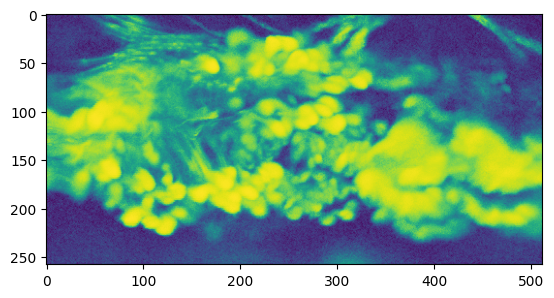

In [14]:
plt.imshow(corrs)

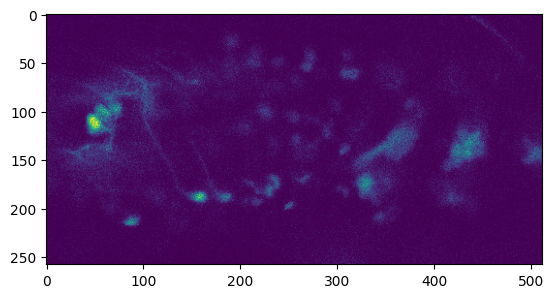

In [15]:
plt.imshow(frames[0])

In [16]:
def build_rois(corrs: np.ndarray, threshold=0.5) -> list:
    corrs_cpy = corrs.copy()
    rois = []
    visited = set()
    for i in range(30000):  # building three rois
        roi = build_roi(corrs_cpy, threshold, visited)
        if roi:
            rois.append(roi)
            visited.update(roi)
    return rois

In [17]:
def build_roi(corrs, threshold, visited):
    masked_corrs = corrs.copy()
    for y, x in visited:
        masked_corrs[y, x] = -np.inf
    roi = set()
    center = np.unravel_index(np.argmax(masked_corrs, axis=None), corrs.shape)
    roi.update(build_roi_recursive(corrs, center, threshold, visited))
    return roi

In [18]:
def build_roi_recursive(corrs: np.ndarray, center: tuple, threshold=0.5,
                        visited: set = None) ->set:
    if visited is None:
        visited = set()
    if center in visited or corrs[center] < threshold:
        return set()
    visited.add(center)

    roi = {center}
    neighbors = get_neighbor_coords(corrs, center[1], center[0])
    for x, y in neighbors:
        if corrs[y, x] > threshold:
            roi.update(build_roi_recursive(corrs, (y, x), threshold, visited))

    return roi
#TODO: use iterative programming

In [24]:
rois = build_rois(corrs, 0.8)


RecursionError: maximum recursion depth exceeded

In [20]:
print(len(rois))

99


In [21]:
def plot_blobs_on_image(image, blobs, color="r", marker="o"):
    """Overlays blobs on an image.

    :param image: 2D NumPy array representing the background image.
    :param blobs: List of blobs, each blob is a list of (y, x) coordinate tuples.
    :param color: Color of the blob markers.
    :param marker: Marker style for blob points (default is 'o').
    """
    plt.imshow(image, cmap="gray")
    for blob in blobs:
        y_coords, x_coords = zip(*blob, strict=False)
        plt.plot(x_coords, y_coords, marker=marker, linestyle="None", markersize=1,
                 color="red")
    plt.title("Blobs on Image")
    plt.axis("off")
    plt.show()

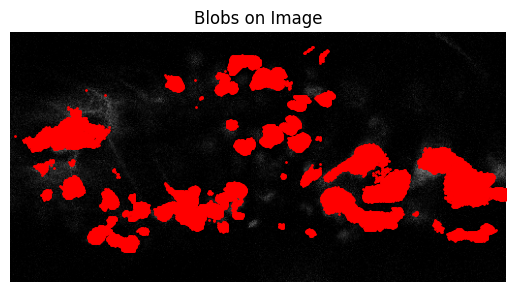

In [22]:
plot_blobs_on_image(frames[0], rois)

In [23]:
from itertools import combinations

for roi1, roi2 in combinations(rois, 2):
    assert roi1.isdisjoint(roi2), "ROIs are overlapping!"